# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [ ]:
!pip install datasets torchmetrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy

from tqdm import tqdm

In [ ]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb", cache_dir="path/to/cache/directory")


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to path/to/cache/directory/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(imdb_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
# Split the train set into train and validation in 80-20 split. Use the labels
# to ensure that the ratio of the samples from each label is maintained
#splitting the data based on the above structure of the dataset
from sklearn.model_selection import train_test_split


train_data = imdb_dataset['train']
train_text = train_data['text']
train_labels = train_data['label']

train_texts, val_texts, train_labels, val_labels = train_test_split(train_text, train_labels, test_size=0.2, stratify=train_labels, random_state=42)
test_texts = imdb_dataset['test']['text']
test_labels = imdb_dataset['test']['label']

In [ ]:
import nltk
import re
from nltk.tokenize import RegexpTokenizer
def clean(text, tokenizer):
  # Perform text preprocessing:
  # 1. Removing numbers OR replace them with "num" token
  # 2. Convert all characters to lowercase.
  # 3. Tokenize the sentence into words
  # You can use RegexpTokenizer from NLTK.
  num_pattern = r'\b\d+\b'\

  text = re.sub(num_pattern, 'num', text)

  text = text.lower()

  text = tokenizer.tokenize(text)

  # You will experiment with stemming/lemmatization down the line
  # so you can skip that for now

  return text

In [ ]:
# create a word to index dictionary so that each word in the training set
# has a number associated with it. This allows to represent each sentence
# as a series of numbers. Start the index with 1 instead of 0. The number
# 0 will be used to denote padding, so that each sentence can have the
# same length.
# Keep track of the index since it will be used for representing new words
# that were not part of the training vocabulary.
# Also, make sure to not create dictionary on sentences with word count
# not within the range
tokenizer = RegexpTokenizer(r'\w+')
def get_word2idx(corpus , minlen , maxlen):
  idx = 1
  word2idx = {}
  #word2idx['pad'] = 0
  for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
    # process sentence
    sentence = clean(sentence, tokenizer)
    words =sentence

    # drop sentences greater than maxlen or less than minlen
    if(minlen<=len(words) and len(words)<=maxlen):
    # for each word in sentence, check for entry in word2idx
      for word in words:
        if word not in word2idx:
          word2idx[word] = idx
          idx += 1


  return idx, word2idx

In [ ]:
vocab_size, word2idx = get_word2idx(train_texts, 100, 500)

Creating word2idx: 100%|██████████| 20000/20000 [00:03<00:00, 5648.02it/s]


In [ ]:
# Build a Dataset object to store each sentence as a tensor of numbers
# along with the label. Make sure to add padding so that the tensor
# for each sentence is of the same length. This will allow us to train
# the model in batches.

class IMDBDataset(Dataset):
  def __init__(self, dataset,labels, word2idx, minlen : int = 100, maxlen : int = 500):
    self.count = 0 # total sentences you finally pick

    # count total number of lines
    #len = len(dataset)

    input_data = []
    target_data = []
    corpus = dataset
    word2idx['UNK'] = vocab_size
    #for idx, sentence in tqdm(enumerate(corpus), total=len, desc=f"Transforming input text [{split}]"):
    for sentence , label in tqdm(zip(dataset,labels),total=len(dataset), desc=f"Transforming input text"):
      # process sentence
      sentence = clean(sentence , tokenizer)
      # drop sentences greater than maxlen or less than minlen
      words = sentence
      if(len(words)<minlen or maxlen<len(words)):continue

      # replace words with their index
      indices= [word2idx.get(word, vocab_size) for word in words]

      #pad_sequence doesnt take in list so for the pad_sequence we need to convert the input list to tensor form then it will accept it
      input_data.append(torch.tensor(indices))

      target_data.append(label)

      self.count += 1

    # pad the sentences upto maxlen
    self.inputs = pad_sequence(input_data, batch_first = True,padding_value=0)
    #self.inputs = torch.tensor(input_data)
    self.targets = torch.tensor(target_data)

  def __len__(self) -> int:
    return self.count

  def __getitem__(self, index : int):
    return self.inputs[index], self.targets[index]

In [ ]:
# create the train dataset using the word2idx dictionary built using the train set
train_ds = IMDBDataset(train_texts , train_labels , word2idx,minlen = 100, maxlen = 500)
# create the validation and test dataset using the word2idx dictionary built using the train set
val_ds = IMDBDataset(val_texts , val_labels , word2idx,minlen = 100, maxlen = 500)
test_ds = IMDBDataset(test_texts , test_labels , word2idx,minlen = 100, maxlen = 500)

Transforming input text: 100%|██████████| 25000/25000 [00:06<00:00, 3759.66it/s]


In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(16059, 4010, 20078)

In [ ]:
# create dataloaders using the dataset
params = {
    'batch_size':256,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

In [ ]:
import torch.nn.functional as F


class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, dropout=0.5):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        #We pass the input tensor of indices to Embedding to get a dense vector embedding of the dimensions embed_size
        embedded = self.embedding(X)
        output, _ = self.rnn(embedded)
        out = torch.max(output, dim=1)[0]
#         pooled = self.dropout(pooled)
        hidden = F.relu(self.fc1(out))
        logits = self.fc2(hidden)
        return logits

In [ ]:
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = len(set(train_labels))
vocab_size = len(word2idx)+1

# create the model
model = RNNModel(vocab_size, hidden_size, embedding_dim, 3,num_classes).to(device)

# create optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

RNNModel(
  (embedding): Embedding(58539, 256)
  (rnn): RNN(256, 128, num_layers=3, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
def train_model(model, trainloader, valloader, learning_rate=1e-3, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_accuracy = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        train_loss = 0.0
        for input_batch, output_batch in tqdm(trainloader, total=len(trainloader), desc="Training"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_batch)

            # Calculate loss
            loss = criterion(outputs, output_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        ## VALIDATION STEP
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for input_batch, output_batch in tqdm(valloader, total=len(valloader), desc="Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)

                # Forward pass
                outputs = model(input_batch)

                # Calculate loss
                loss = criterion(outputs, output_batch)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += output_batch.size(0)
                correct += (predicted == output_batch).sum().item()

        val_loss /= len(valloader)
        val_losses.append(val_loss)
        accuracy = 100 * correct / total
        val_accuracy.append(accuracy)

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

        # Save the best model
        if epoch == 6:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)
    return train_losses, val_losses, val_accuracy



In [ ]:
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader)

Validation: 100%|██████████| 16/16 [00:00<00:00, 47.57it/s]


Epoch 1/10: Train Loss: 0.6937, Val Loss: 0.6763, Val Accuracy: 59.33%


Validation: 100%|██████████| 16/16 [00:00<00:00, 52.28it/s]


Epoch 2/10: Train Loss: 0.6327, Val Loss: 0.6021, Val Accuracy: 66.96%


Validation: 100%|██████████| 16/16 [00:00<00:00, 54.94it/s]


Epoch 3/10: Train Loss: 0.4973, Val Loss: 0.5837, Val Accuracy: 72.49%


Validation: 100%|██████████| 16/16 [00:00<00:00, 53.30it/s]


Epoch 4/10: Train Loss: 0.3769, Val Loss: 0.4294, Val Accuracy: 81.60%


Validation: 100%|██████████| 16/16 [00:00<00:00, 54.31it/s]


Epoch 5/10: Train Loss: 0.2872, Val Loss: 0.4055, Val Accuracy: 81.75%


Validation: 100%|██████████| 16/16 [00:00<00:00, 56.20it/s]


Epoch 6/10: Train Loss: 0.2149, Val Loss: 0.3762, Val Accuracy: 84.14%


Validation: 100%|██████████| 16/16 [00:00<00:00, 53.13it/s]


Epoch 7/10: Train Loss: 0.1782, Val Loss: 0.3681, Val Accuracy: 85.81%


Validation: 100%|██████████| 16/16 [00:00<00:00, 54.55it/s]


Epoch 8/10: Train Loss: 0.1283, Val Loss: 0.4752, Val Accuracy: 83.77%


Validation: 100%|██████████| 16/16 [00:00<00:00, 54.42it/s]


Epoch 9/10: Train Loss: 0.1212, Val Loss: 0.4259, Val Accuracy: 85.46%


Validation: 100%|██████████| 16/16 [00:00<00:00, 53.69it/s]

Epoch 10/10: Train Loss: 0.0742, Val Loss: 0.4734, Val Accuracy: 84.71%


In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for input_batch, output_batch in tqdm(test_loader):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            #get outputs from the trained model
            pred_outputs = model(input_batch)
            _, predicted = torch.max(pred_outputs, dim=1)  # Get predicted class labels
            total += output_batch.size(0)
            correct += (predicted == output_batch).sum().item()

    accuracy = 100 * (correct / total)
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

accuracy = test(model, test_dataloader)


100%|██████████| 79/79 [00:01<00:00, 68.13it/s]

Test Accuracy: 82.57%


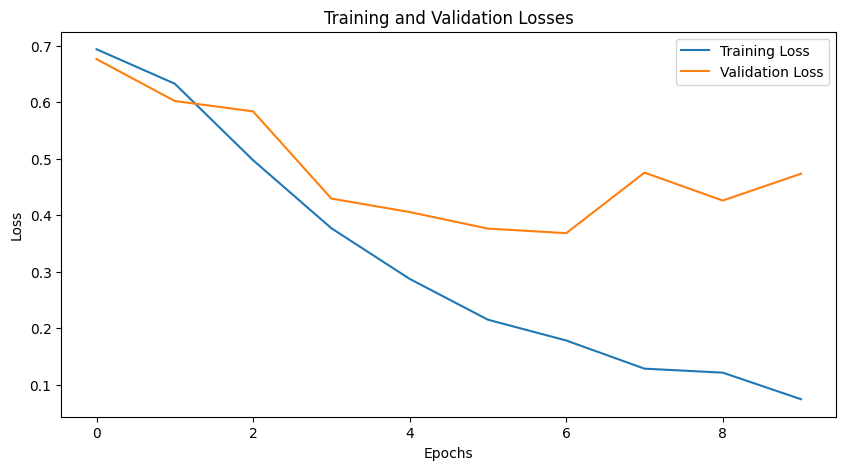

In [ ]:
# plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

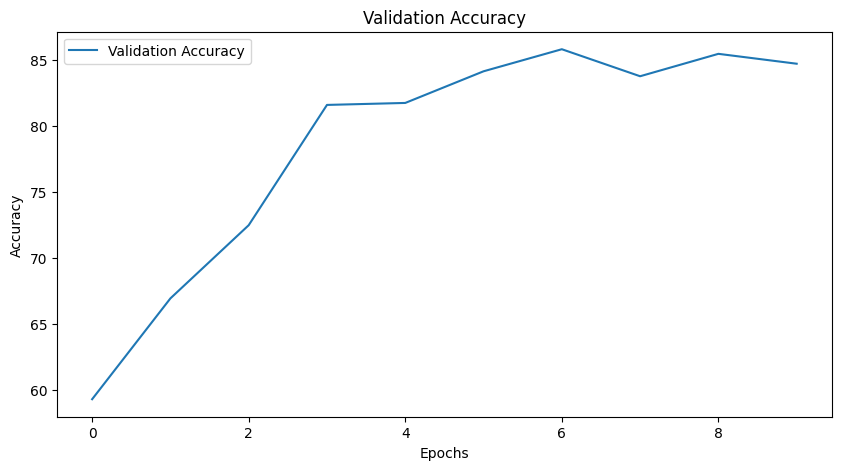

In [ ]:
# plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [ ]:
# import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from nltk.tokenize import RegexpTokenizer
def clean(text, tokenizer):
  # Perform text preprocessing:
  # 1. Removing numbers OR replace them with "num" token
  # 2. Convert all characters to lowercase.
  # 3. Tokenize the sentence into words
  # You can use RegexpTokenizer from NLTK.
  num_pattern = r'\b\d+\b'\

  text = re.sub(num_pattern, 'num', text)

  text = text.lower()

  text = tokenizer.tokenize(text)
  #stemming
  stemmer = PorterStemmer()
  stem_words = [stemmer.stem(word) for word in text]

  # You will experiment with stemming/lemmatization down the line
  # so you can skip that for now

  return stem_words
tokenizer = RegexpTokenizer(r'\w+')

def get_word2idx(corpus , minlen , maxlen):
  idx = 1
  word2idx = {}
  #word2idx['pad'] = 0
  for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
    # process sentence
    sentence = clean(sentence, tokenizer)
    words =sentence

    # drop sentences greater than maxlen or less than minlen
    if(minlen<=len(words) and len(words)<=maxlen):
    # for each word in sentence, check for entry in word2idx
      for word in words:
        if word not in word2idx:
          word2idx[word] = idx
          idx += 1


  return idx, word2idx
vocab_size1,word2idx1 = get_word2idx(train_texts,100,500)
# Build a Dataset object to store each sentence as a tensor of numbers
# along with the label. Make sure to add padding so that the tensor
# for each sentence is of the same length. This will allow us to train
# the model in batches.

class IMDBDataset(Dataset):
  def __init__(self, dataset,labels, word2idx, minlen : int = 100, maxlen : int = 500):
    self.count = 0 # total sentences you finally pick

    # count total number of lines
    #len = len(dataset)

    input_data = []
    target_data = []
    corpus = dataset
    word2idx['UNK'] = vocab_size1
    #for idx, sentence in tqdm(enumerate(corpus), total=len, desc=f"Transforming input text [{split}]"):
    for sentence , label in tqdm(zip(dataset,labels),total=len(dataset), desc=f"Transforming input text"):
      # process sentence
      sentence = clean(sentence , tokenizer)
      # drop sentences greater than maxlen or less than minlen
      words = sentence
      if(len(words)<minlen or maxlen<len(words)):continue

      # replace words with their index
      indices= [word2idx.get(word, vocab_size1) for word in words]

      #pad_sequence doesnt take in list so for the pad_sequence we need to convert the input list to tensor form then it will accept it
      input_data.append(torch.tensor(indices))

      target_data.append(label)

      self.count += 1

    # pad the sentences upto maxlen
    self.inputs = pad_sequence(input_data, batch_first = True,padding_value=0)
    #self.inputs = torch.tensor(input_data)
    self.targets = torch.tensor(target_data)

  def __len__(self) -> int:
    return self.count

  def __getitem__(self, index : int):
    return self.inputs[index], self.targets[index]
# create the train dataset using the word2idx dictionary built using the train set
train_ds = IMDBDataset(train_texts , train_labels , word2idx1,minlen = 100, maxlen = 500)
# create the validation and test dataset using the word2idx dictionary built using the train set
val_ds = IMDBDataset(val_texts , val_labels , word2idx1,minlen = 100, maxlen = 500)
test_ds = IMDBDataset(test_texts , test_labels , word2idx1,minlen = 100, maxlen = 500)


Transforming input text: 100%|██████████| 25000/25000 [02:45<00:00, 150.62it/s]


In [ ]:
# create dataloaders using the dataset
params = {
    'batch_size':256,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = len(set(train_labels))
vocab_size = len(word2idx)+1

# create the model
model1 = RNNModel(vocab_size, hidden_size, embedding_dim,3, num_classes).to(device)


In [ ]:
train_losses, val_losses, val_accuracy = train_model(model1, train_dataloader, val_dataloader)

Validation: 100%|██████████| 16/16 [00:00<00:00, 52.13it/s]


Epoch 1/10: Train Loss: 0.6942, Val Loss: 0.6884, Val Accuracy: 54.86%


Validation: 100%|██████████| 16/16 [00:00<00:00, 51.83it/s]


Epoch 2/10: Train Loss: 0.6531, Val Loss: 0.5630, Val Accuracy: 72.47%


Validation: 100%|██████████| 16/16 [00:00<00:00, 52.18it/s]


Epoch 3/10: Train Loss: 0.4887, Val Loss: 0.4398, Val Accuracy: 79.75%


Validation: 100%|██████████| 16/16 [00:00<00:00, 52.34it/s]


Epoch 4/10: Train Loss: 0.3828, Val Loss: 0.4095, Val Accuracy: 82.14%


Validation: 100%|██████████| 16/16 [00:00<00:00, 46.79it/s]


Epoch 5/10: Train Loss: 0.2990, Val Loss: 0.3740, Val Accuracy: 83.69%


Validation: 100%|██████████| 16/16 [00:00<00:00, 49.44it/s]


Epoch 6/10: Train Loss: 0.2515, Val Loss: 0.3805, Val Accuracy: 85.29%


Validation: 100%|██████████| 16/16 [00:00<00:00, 47.46it/s]


Epoch 7/10: Train Loss: 0.1984, Val Loss: 0.4376, Val Accuracy: 83.19%


Validation: 100%|██████████| 16/16 [00:00<00:00, 50.47it/s]


Epoch 8/10: Train Loss: 0.1697, Val Loss: 0.4101, Val Accuracy: 83.54%


Validation: 100%|██████████| 16/16 [00:00<00:00, 50.93it/s]


Epoch 9/10: Train Loss: 0.1328, Val Loss: 0.4180, Val Accuracy: 85.89%


Validation: 100%|██████████| 16/16 [00:00<00:00, 51.92it/s]


Epoch 10/10: Train Loss: 0.1195, Val Loss: 0.4908, Val Accuracy: 83.79%


# Observations:
* It is giving better accuracies after doing stemming.

#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

In [ ]:
class RNNMeanModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, dropout=0.5):
        super(RNNMeanModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        #We pass the input tensor of indices to Embedding to get a dense vector embedding of the dimensions embed_size
        embedded = self.embedding(X)
        output, _ = self.rnn(embedded)
        mean_out = torch.mean(output, dim=1)
        hidden = F.relu(self.fc1(mean_out))
        logits = self.fc2(hidden)
        return logits

In [ ]:
mean_model = RNNMeanModel(vocab_size,hidden_size,embedding_dim,3,num_classes).to(device)
train_losses, val_losses, val_accuracy = train_model(mean_model, train_dataloader, val_dataloader)

Validation: 100%|██████████| 16/16 [00:00<00:00, 49.70it/s]


Epoch 1/10: Train Loss: 0.6879, Val Loss: 0.6669, Val Accuracy: 62.02%


Validation: 100%|██████████| 16/16 [00:00<00:00, 48.25it/s]


Epoch 2/10: Train Loss: 0.5560, Val Loss: 0.4584, Val Accuracy: 79.28%


Validation: 100%|██████████| 16/16 [00:00<00:00, 50.38it/s]


Epoch 3/10: Train Loss: 0.3858, Val Loss: 0.3923, Val Accuracy: 82.72%


Validation: 100%|██████████| 16/16 [00:00<00:00, 45.23it/s]


Epoch 4/10: Train Loss: 0.2988, Val Loss: 0.3921, Val Accuracy: 83.34%


Validation: 100%|██████████| 16/16 [00:00<00:00, 49.96it/s]


Epoch 5/10: Train Loss: 0.2295, Val Loss: 0.3767, Val Accuracy: 85.04%


Validation: 100%|██████████| 16/16 [00:00<00:00, 50.40it/s]


Epoch 6/10: Train Loss: 0.1784, Val Loss: 0.3879, Val Accuracy: 84.74%


Validation: 100%|██████████| 16/16 [00:00<00:00, 47.01it/s]


Epoch 7/10: Train Loss: 0.1384, Val Loss: 0.3985, Val Accuracy: 85.66%


Validation: 100%|██████████| 16/16 [00:00<00:00, 49.04it/s]


Epoch 8/10: Train Loss: 0.3164, Val Loss: 0.4071, Val Accuracy: 84.86%


Validation: 100%|██████████| 16/16 [00:00<00:00, 50.67it/s]


Epoch 9/10: Train Loss: 0.1383, Val Loss: 0.3855, Val Accuracy: 86.23%


Validation: 100%|██████████| 16/16 [00:00<00:00, 51.43it/s]

Epoch 10/10: Train Loss: 0.0937, Val Loss: 0.4325, Val Accuracy: 85.94%


# Observations:
* It is giving better accuracies when we took the mean of all the layers instead of last layer.

### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [ ]:
hyperparameters = [
    {'embedding_dim': 64, 'hidden_size': 64, 'batch_size': 256},
    {'embedding_dim': 128, 'hidden_size': 128, 'batch_size': 128},
    {'embedding_dim': 256, 'hidden_size': 256, 'batch_size': 128},
    {'embedding_dim': 128, 'hidden_size':256, 'batch_size': 256},
    {'embedding_dim': 64, 'hidden_size': 128, 'batch_size': 64}
]
results = []

for params in hyperparameters:
    embedding_dim = params['embedding_dim']
    hidden_size = params['hidden_size']
    batch_size = params['batch_size']

    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,num_workers =2)
    val_dataloader = DataLoader(val_ds, batch_size=batch_size,shuffle =True,num_workers = 2)

    learning_rate = 1e-3
    epochs = 10
    num_classes = 2
    vocab_size = len(word2idx1)+1

    model = RNNModel(vocab_size, hidden_size, embedding_dim,3, num_classes).to(device)

    train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader , epochs)

    results.append({
        'config': params,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracy': val_accuracy
    })

for i, result in enumerate(results):
    config = result['config']
    print(f"\nConfiguration {i + 1}:")
    print(f"Embedding Dimension: {config['embedding_dim']}, Hidden Size: {config['hidden_size']}, Batch Size: {config['batch_size']},")
    print("validation_accuracy",result['val_accuracy'])



Validation: 100%|██████████| 16/16 [00:00<00:00, 82.28it/s]


Epoch 1/10: Train Loss: 758.4121, Val Loss: 0.6958, Val Accuracy: 48.43%


Validation: 100%|██████████| 16/16 [00:00<00:00, 86.00it/s]


Epoch 2/10: Train Loss: 0.7206, Val Loss: 0.9564, Val Accuracy: 48.43%


Validation: 100%|██████████| 16/16 [00:00<00:00, 83.40it/s]


Epoch 3/10: Train Loss: 0.7566, Val Loss: 0.7847, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 83.29it/s]


Epoch 4/10: Train Loss: 0.8328, Val Loss: 0.9006, Val Accuracy: 48.43%


Validation: 100%|██████████| 16/16 [00:00<00:00, 86.56it/s]


Epoch 5/10: Train Loss: 0.7553, Val Loss: 0.7917, Val Accuracy: 48.43%


Validation: 100%|██████████| 16/16 [00:00<00:00, 85.67it/s]


Epoch 6/10: Train Loss: 0.7507, Val Loss: 0.7192, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 76.50it/s]


Epoch 7/10: Train Loss: 0.8083, Val Loss: 0.9573, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 86.20it/s]


Epoch 8/10: Train Loss: 0.8348, Val Loss: 0.8046, Val Accuracy: 48.43%


Validation: 100%|██████████| 16/16 [00:00<00:00, 88.64it/s]


Epoch 9/10: Train Loss: 0.7489, Val Loss: 0.7043, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 86.59it/s]


Epoch 10/10: Train Loss: 0.7522, Val Loss: 0.7129, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 96.99it/s]


Epoch 1/10: Train Loss: 1034.5639, Val Loss: 0.7035, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 97.63it/s] 


Epoch 2/10: Train Loss: 0.7510, Val Loss: 0.7089, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 98.48it/s] 


Epoch 3/10: Train Loss: 0.7863, Val Loss: 0.7001, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 100.04it/s]


Epoch 4/10: Train Loss: 0.7727, Val Loss: 0.7558, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 98.11it/s] 


Epoch 5/10: Train Loss: 0.8422, Val Loss: 0.7195, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 98.92it/s] 


Epoch 6/10: Train Loss: 0.8845, Val Loss: 0.7068, Val Accuracy: 51.57%


Validation: 100%|██████████| 32/32 [00:00<00:00, 99.75it/s] 


Epoch 7/10: Train Loss: 0.7803, Val Loss: 0.8940, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 99.07it/s] 


Epoch 8/10: Train Loss: 0.8674, Val Loss: 0.8016, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 94.20it/s] 


Epoch 9/10: Train Loss: 0.8068, Val Loss: 0.6929, Val Accuracy: 51.57%


Validation: 100%|██████████| 32/32 [00:00<00:00, 101.78it/s]


Epoch 10/10: Train Loss: 0.7543, Val Loss: 0.8350, Val Accuracy: 51.57%


Validation: 100%|██████████| 32/32 [00:00<00:00, 36.39it/s]


Epoch 1/10: Train Loss: 7745.8063, Val Loss: 0.7576, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 35.89it/s]


Epoch 2/10: Train Loss: 0.7895, Val Loss: 0.8158, Val Accuracy: 51.57%


Validation: 100%|██████████| 32/32 [00:00<00:00, 36.29it/s]


Epoch 3/10: Train Loss: 0.7879, Val Loss: 0.7812, Val Accuracy: 51.57%


Validation: 100%|██████████| 32/32 [00:00<00:00, 35.76it/s]


Epoch 4/10: Train Loss: 0.7844, Val Loss: 0.7536, Val Accuracy: 51.57%


Validation: 100%|██████████| 32/32 [00:00<00:00, 35.50it/s]


Epoch 5/10: Train Loss: 0.8590, Val Loss: 0.7710, Val Accuracy: 51.57%


Validation: 100%|██████████| 32/32 [00:00<00:00, 35.40it/s]


Epoch 6/10: Train Loss: 0.8502, Val Loss: 0.6959, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 35.84it/s]


Epoch 7/10: Train Loss: 0.7892, Val Loss: 0.7246, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 35.81it/s]


Epoch 8/10: Train Loss: 0.8176, Val Loss: 0.9081, Val Accuracy: 51.57%


Validation: 100%|██████████| 32/32 [00:00<00:00, 36.26it/s]


Epoch 9/10: Train Loss: 0.8377, Val Loss: 0.9632, Val Accuracy: 48.43%


Validation: 100%|██████████| 32/32 [00:00<00:00, 35.74it/s]


Epoch 10/10: Train Loss: 0.8107, Val Loss: 0.7620, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 51.92it/s]


Epoch 1/10: Train Loss: 5042.9983, Val Loss: 0.8562, Val Accuracy: 48.43%


Validation: 100%|██████████| 16/16 [00:00<00:00, 53.02it/s]


Epoch 2/10: Train Loss: 0.7745, Val Loss: 0.7435, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 51.65it/s]


Epoch 3/10: Train Loss: 0.7093, Val Loss: 0.6932, Val Accuracy: 48.43%


Validation: 100%|██████████| 16/16 [00:00<00:00, 51.14it/s]


Epoch 4/10: Train Loss: 0.7257, Val Loss: 0.7344, Val Accuracy: 48.43%


Validation: 100%|██████████| 16/16 [00:00<00:00, 51.17it/s]


Epoch 5/10: Train Loss: 0.7342, Val Loss: 0.8055, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 53.61it/s]


Epoch 6/10: Train Loss: 0.7540, Val Loss: 0.6927, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 51.22it/s]


Epoch 7/10: Train Loss: 0.7383, Val Loss: 0.7902, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 52.29it/s]


Epoch 8/10: Train Loss: 0.7408, Val Loss: 0.9000, Val Accuracy: 48.43%


Validation: 100%|██████████| 16/16 [00:00<00:00, 51.53it/s]


Epoch 9/10: Train Loss: 0.7611, Val Loss: 0.6937, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 50.91it/s]


Epoch 10/10: Train Loss: 0.7432, Val Loss: 0.7020, Val Accuracy: 48.43%


Validation: 100%|██████████| 63/63 [00:00<00:00, 194.26it/s]


Epoch 1/10: Train Loss: 159.8980, Val Loss: 0.6932, Val Accuracy: 51.57%


Validation: 100%|██████████| 63/63 [00:00<00:00, 200.25it/s]


Epoch 2/10: Train Loss: 0.8118, Val Loss: 0.8752, Val Accuracy: 48.43%


Validation: 100%|██████████| 63/63 [00:00<00:00, 181.61it/s]


Epoch 3/10: Train Loss: 0.8520, Val Loss: 1.2572, Val Accuracy: 48.43%


Validation: 100%|██████████| 63/63 [00:00<00:00, 197.87it/s]


Epoch 4/10: Train Loss: 0.8406, Val Loss: 0.7960, Val Accuracy: 48.43%


Validation: 100%|██████████| 63/63 [00:00<00:00, 192.91it/s]


Epoch 5/10: Train Loss: 0.8547, Val Loss: 0.9860, Val Accuracy: 51.57%


Validation: 100%|██████████| 63/63 [00:00<00:00, 193.18it/s]


Epoch 6/10: Train Loss: 0.8894, Val Loss: 0.7041, Val Accuracy: 48.43%


Validation: 100%|██████████| 63/63 [00:00<00:00, 193.93it/s]


Epoch 7/10: Train Loss: 0.8530, Val Loss: 0.6954, Val Accuracy: 51.57%


Validation: 100%|██████████| 63/63 [00:00<00:00, 197.56it/s]


Epoch 8/10: Train Loss: 0.8576, Val Loss: 0.6933, Val Accuracy: 48.43%


Validation: 100%|██████████| 63/63 [00:00<00:00, 191.96it/s]


Epoch 9/10: Train Loss: 1.0124, Val Loss: 0.7017, Val Accuracy: 51.57%


Validation: 100%|██████████| 63/63 [00:00<00:00, 183.92it/s]

Epoch 10/10: Train Loss: 0.9344, Val Loss: 0.8274, Val Accuracy: 51.57%

Configuration 1:
Embedding Dimension: 64, Hidden Size: 64, Batch Size: 256,
validation_accuracy [48.428927680798004, 48.428927680798004, 51.571072319201996, 48.428927680798004, 48.428927680798004, 51.571072319201996, 51.571072319201996, 48.428927680798004, 51.571072319201996, 48.428927680798004]

Configuration 2:
Embedding Dimension: 128, Hidden Size: 128, Batch Size: 128,
validation_accuracy [48.428927680798004, 48.428927680798004, 48.428927680798004, 48.428927680798004, 48.428927680798004, 51.571072319201996, 48.428927680798004, 48.428927680798004, 51.571072319201996, 51.571072319201996]

Configuration 3:
Embedding Dimension: 256, Hidden Size: 256, Batch Size: 128,
validation_accuracy [48.428927680798004, 51.571072319201996, 51.571072319201996, 51.571072319201996, 51.571072319201996, 48.428927680798004, 48.428927680798004, 51.571072319201996, 48.428927680798004, 51.571072319201996]

Configuration 4:
Embedding Di

### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [ ]:
# Define the LSTM model with 2 layers
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)
        lstm_out1, _ = self.lstm1(embedded)
        lstm_out2, _ = self.lstm2(lstm_out1)
        logits = self.fc(lstm_out2[:, -1, :])
        return logits


In [ ]:
# create dataloaders using the dataset
params = {
    'batch_size':256,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 15
num_classes = len(set(train_labels))
vocab_size = len(word2idx)+1

# create the model
model_LSTM = LSTMModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)


In [ ]:
train_losses, val_losses, val_accuracy = train_model(model_LSTM, train_dataloader, val_dataloader , epochs = epochs)

Validation: 100%|██████████| 16/16 [00:00<00:00, 21.95it/s]


Epoch 1/15: Train Loss: 0.6937, Val Loss: 0.6926, Val Accuracy: 51.55%


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.83it/s]


Epoch 2/15: Train Loss: 0.6931, Val Loss: 0.6930, Val Accuracy: 51.55%


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.96it/s]


Epoch 3/15: Train Loss: 0.6931, Val Loss: 0.6928, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 22.05it/s]


Epoch 4/15: Train Loss: 0.6929, Val Loss: 0.6927, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 22.07it/s]


Epoch 5/15: Train Loss: 0.6931, Val Loss: 0.6927, Val Accuracy: 51.57%


Validation: 100%|██████████| 16/16 [00:00<00:00, 22.04it/s]


Epoch 6/15: Train Loss: 0.6927, Val Loss: 0.6929, Val Accuracy: 51.60%


Validation: 100%|██████████| 16/16 [00:00<00:00, 22.17it/s]


Epoch 7/15: Train Loss: 0.6886, Val Loss: 0.6628, Val Accuracy: 61.62%


Validation: 100%|██████████| 16/16 [00:00<00:00, 22.12it/s]


Epoch 8/15: Train Loss: 0.6080, Val Loss: 0.5671, Val Accuracy: 71.40%


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.88it/s]


Epoch 9/15: Train Loss: 0.5320, Val Loss: 0.6215, Val Accuracy: 65.49%


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.84it/s]


Epoch 10/15: Train Loss: 0.4680, Val Loss: 0.4921, Val Accuracy: 79.15%


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.76it/s]


Epoch 11/15: Train Loss: 0.3362, Val Loss: 0.4413, Val Accuracy: 81.82%


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.97it/s]


Epoch 12/15: Train Loss: 0.2616, Val Loss: 0.4774, Val Accuracy: 80.82%


Validation: 100%|██████████| 16/16 [00:00<00:00, 22.09it/s]


Epoch 13/15: Train Loss: 0.2090, Val Loss: 0.4655, Val Accuracy: 82.24%


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.97it/s]


Epoch 14/15: Train Loss: 0.1701, Val Loss: 0.5204, Val Accuracy: 81.42%


Validation: 100%|██████████| 16/16 [00:00<00:00, 22.01it/s]

Epoch 15/15: Train Loss: 0.1401, Val Loss: 0.5751, Val Accuracy: 81.70%


In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for input_batch, output_batch in tqdm(test_loader):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            #get outputs from the trained model
            pred_outputs = model(input_batch)
            _, predicted = torch.max(pred_outputs, dim=1)  # Get predicted class labels
            total += output_batch.size(0)
            correct += (predicted == output_batch).sum().item()

    accuracy = 100 * (correct / total)
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

accuracy = test(model_LSTM, test_dataloader)

100%|██████████| 79/79 [00:03<00:00, 24.12it/s]

Test Accuracy: 81.70%
